# Лабораторная работа 6. 

# Cегментация изображений


В этой работе рассматриваются методы сегментации изображений.

Цель лабораторной работы: научиться применять методы сегментации изображений.

#
Настроим Jupyter на отображение полного интерактивного вывода:

#
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

### Дополнительные библиотеки

- https://scikit-learn.org/stable/
- conda install -c anaconda scikit-learn

- https://scikit-image.org/
- conda install -c anaconda scikit-image

In [4]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
import sys
sys.path.append('../')
import numpy as np
import cv2 as cv
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import KMeans
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage import data
from scipy import ndimage
import matplotlib.pyplot as plt
from utility import segmentation_utils


### Загрузим изображение

In [2]:
image = cv.imread('../3.jpg')
image_hsv = cv.cvtColor(image, cv.COLOR_RGB2HSV)
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

### 1 Основанные на регионах (Region-based)  Разрастание областей (region growing)

Этот класс алгоритмов эксплуатирует идею, что находящиеся рядом пиксели и при этом схожие по яркости (цвету) должны находиться в одном сегменте.

Существует два основных подхода – объединение пикселей в сегменты и разделение крупных частей изображения на сегменты.

Алгоритм разрастания областей (region growing) - метод сегментации изображения, который работает по принципу итеративного объединения пикселей в области на основе их сходства с начальным (seed) пикселем.

1. Выбор начального значения. Могут быть выбраны вручную, случайным образом или автоматически. 

2. Вычисление сходства. Значение меры сходства определяет, следует ли включать пиксель в увеличивающуюся область. Мера сходства может быть основана на яркости пикселей, цвете, текстуре или комбинации признаков.

3. Определение связности. Алгоритм учитывает связность между соседними пикселями (например, 4 и 8-пиксельную).  
| 4-пиксельная | 8-пиксельная |
| - | - |
| 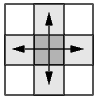|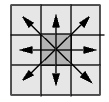|

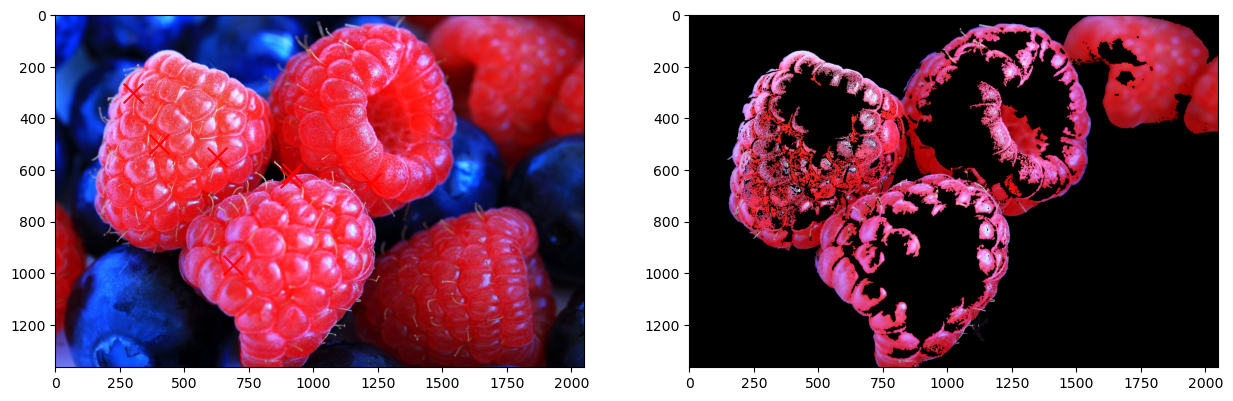

In [4]:
# определяем координаты начальных точек
seeds = [(300, 300), (550, 625), (650, 1225), (610, 919),(970, 690),(630, 910),(500, 400)]
# координаты для графика
x = list(map(lambda x: x[1], seeds))
y = list(map(lambda x: x[0], seeds))
# порог похожести цвета региона
threshold = 100
# находим сегментацию используя метод из segmentation_utils
segmented_region = segmentation_utils.region_growingHSV(image_hsv, seeds, threshold)
# накладываем маску - отображаем только участки попавшие в какой-либо сегмент
result = cv.bitwise_and(image, image, mask=segmented_region)
# отображаем полученное изображение
plt.figure(figsize=(15,20))
plt.subplot(1, 2, 1)
plt.scatter(x, y, marker="x", color="red", s=200)
plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
plt.show()

### Основанные на регионах (Region-based) Метод деления (Split segmentation)

Алгоритм основан на идее, что если область изображения неоднородна, то ее необходимо разделить.

1 Всё изображение есть сегмент, помещаем его в очередь.

2. Пока очередь не пуста
   2.1 Взять сегмент Si из очереди
   2.2 Вычислить меру однородности сегмента
   2.3 Если сегмент неоднороден, то разделить, поместив части в очередь.
   
Деление часто делают на 4 части, тогда возникает структура - квадродерево.

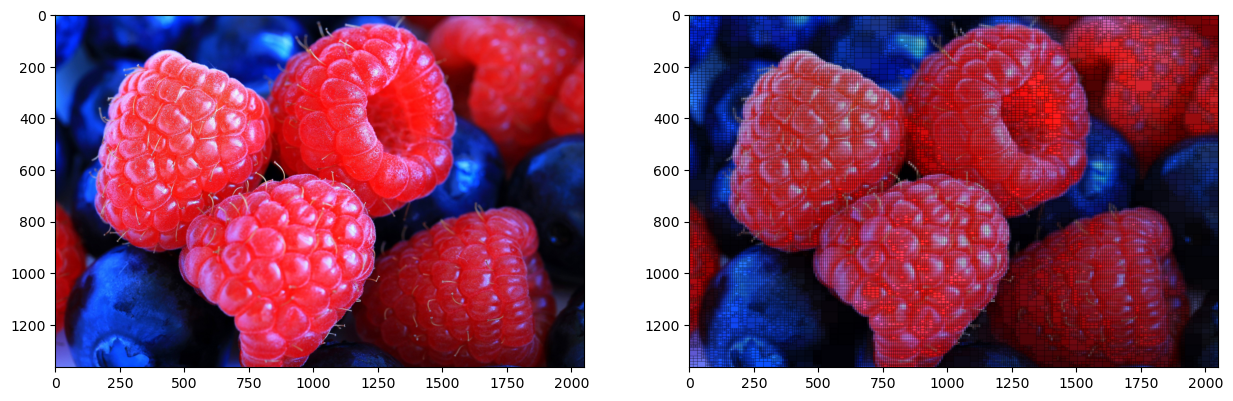

In [10]:
qt = segmentation_utils.QTree(stdThreshold = 0.5, minPixelSize = 4,img = image.copy()) 
qt.subdivide()
tree_image = qt.render_img(thickness=1, color=(0,0,0))

plt.figure(figsize=(15,20))
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(tree_image, cv.COLOR_BGR2RGB))
plt.show()


### Алгоритм водораздела (Watershed)

Алгоритм основан на представлении изображения как топографической поверхности, заполняемой водой. Тогда границы сегментов – это линии водораздела.

На такой поверхности существует 3 типа точек:

  1 Локальные минимумы. 

  2 Точки, в которых вода скатывается в  единственный локальный минимум.

  3 Точки, в которых вода может с равной вероятностью скатиться в несколько минимумов.

Точки, удовлетворяющие 2-му условию, называются водосборным бассейном.

Точки, которые удовлетворяют 3-му условию, называются линиями водораздела. Их необходимо найти.

C:\Users\student\AppData\Local\Temp\ipykernel_6620\3093055374.py:7: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_max = peak_local_max(distance_map, indices=False, min_distance=20, labels=binary_image)


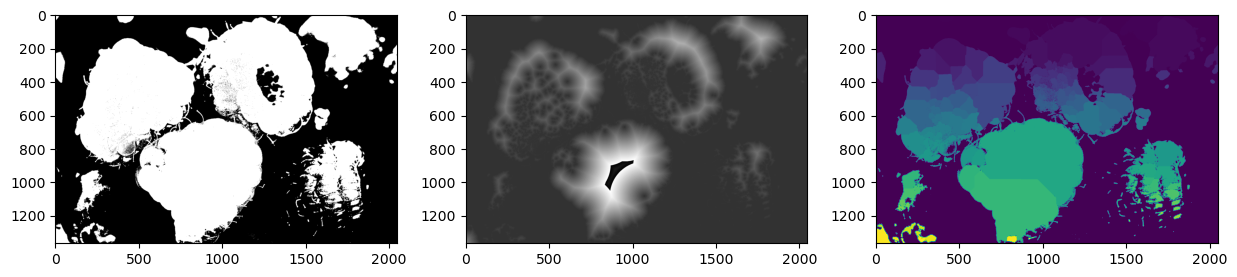

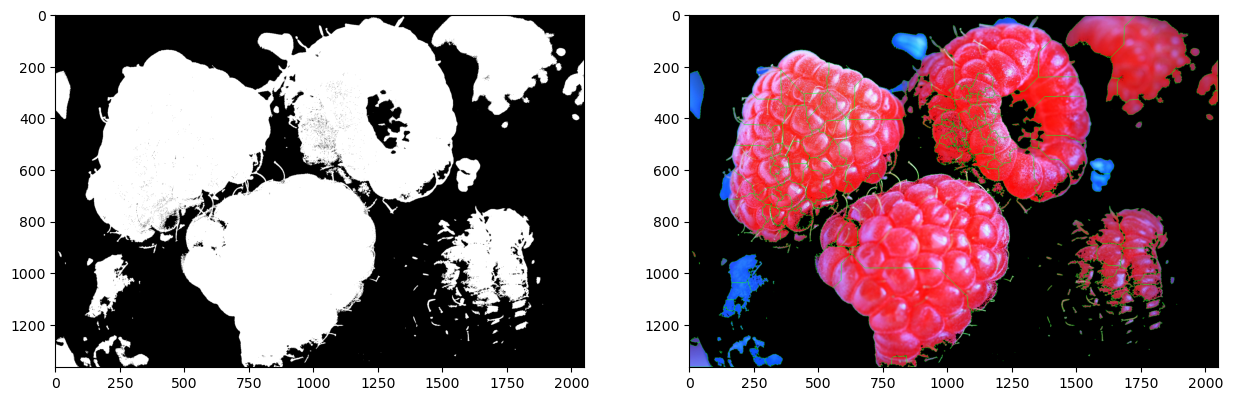

In [5]:
# Алгоритм водораздела
# Бинаризируем изображение
binary_image = cv.threshold(gray, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)[1]
# Определяем карту расстояний
distance_map = ndimage.distance_transform_edt(binary_image)
# Определяем локальные максимумы
local_max = peak_local_max(distance_map, indices=False, min_distance=20, labels=binary_image)
# 4 Каждому минимуму присваивается метка и начинается заполнение бассейнов метками
markers = ndimage.label(local_max, structure=np.ones((3, 3)))[0]
labels = watershed(-distance_map, markers, mask=binary_image)
# построим результаты работы алгоритма
plt.figure(figsize=(15,20))
plt.subplot(1, 3, 1)
plt.imshow(binary_image, cmap="gray")
plt.subplot(1, 3, 2)
plt.imshow(np.uint8(distance_map + 50), cmap="gray")
plt.subplot(1, 3, 3)
plt.imshow(np.uint8(labels))
plt.show()

# Найдем границы контуров и положим в маску все кроме метки 0
mask1 = np.zeros(image.shape[0:2], dtype="uint8")
total_area = 0
for label in np.unique(labels):
    if label < 2:
        continue
    # Create a mask
    mask = np.zeros(gray.shape, dtype="uint8")
    mask[labels == label] = 255
    mask1 = mask1 + mask

    # Find contours and determine contour area
    cnts = cv.findContours(mask.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    c = max(cnts, key=cv.contourArea)
    area = cv.contourArea(c)
    total_area += area
    cv.drawContours(image, [c], -1, (36,255,12), 1)

result = cv.bitwise_and(image, image, mask=mask1)

plt.figure(figsize=(15,20))
plt.subplot(1, 2, 1)
plt.imshow(mask1, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
plt.show()

### 4 Методы кластеризации.

#### K-средних

  Для алгоритма необходимо задать число кластеров (сегментов), после чего границы кластеров изменяются итерационно, минимизируя сумму расстояний от точек до центров кластеров (расстояние по яркости, например).
  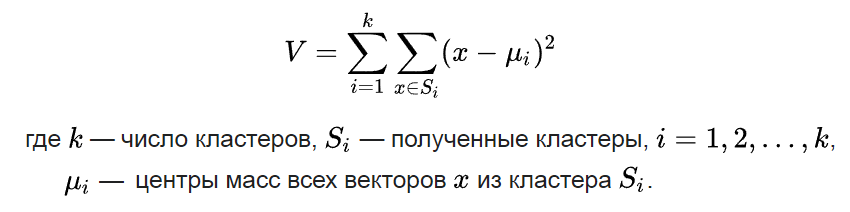

Алгоритм чувствителен к начальному выбору центров кластеров и не учитывает пространственную близость пикселей.




C:\Users\student\.conda\envs\seva\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[ 31]
 [155]
 [ 93]]


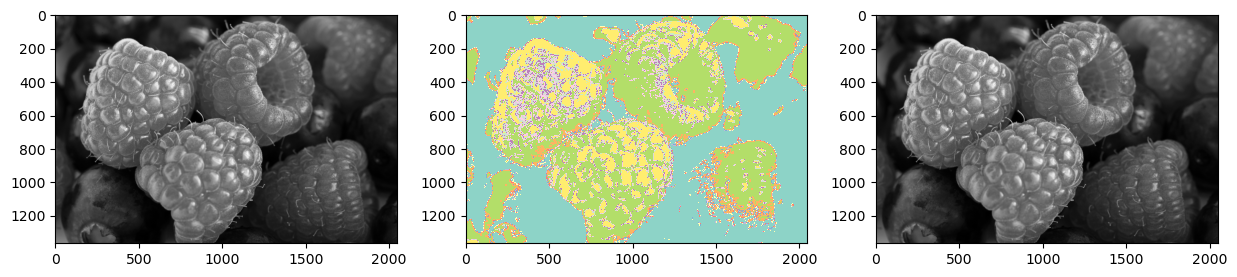

In [11]:
## Методы кластеризации. K-средних
# Преобразуем изображение в оттенках серого в одномерный массив
pixels = gray.reshape(-1, 1)
# Задаем число кластеров для сегментации
K = 3
# С помощью библиотеки sklearn.cluster import KMeans проводим кластеризацию по яркости
kmeans = KMeans(n_clusters=K, random_state=0)
labels = kmeans.fit_predict(pixels)
cluster_centers = kmeans.cluster_centers_
print (np.uint8(cluster_centers))
# Каждому пикселю назначаем значение из центра кластера
segments = np.uint8(cluster_centers[labels].reshape(gray.shape))
# Удалим самые яркие пиксели
segments[segments==167] = 0
result = cv.bitwise_and(gray, gray, mask=segments)
# Отобразим избражения 
plt.figure(figsize=(15,20))
plt.subplot(1, 3, 1)
plt.imshow(cv.cvtColor(gray, cv.COLOR_BGR2RGB))
plt.subplot(1, 3, 2)
plt.imshow(segments, cmap='Set3')
plt.subplot(1, 3, 3)
plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
plt.show()


#### Сдвиг среднего (Mean shift)
  
 https://ru.wikipedia.org/wiki/%D0%A1%D0%B4%D0%B2%D0%B8%D0%B3_%D1%81%D1%80%D0%B5%D0%B4%D0%BD%D0%B5%D0%B3%D0%BE_%D0%B7%D0%BD%D0%B0%D1%87%D0%B5%D0%BD%D0%B8%D1%8F
 
 Метод основан на непараметрической оценке плотности распределения признаков пикселей (яркость, градиент и т.п.). 
 Для непараметрической оценки применяются ядерные функции.
 Алгоритм сдвига среднего ищет локальные максимуму плотности распределения в n-мерном пространстве признаков.
  

    1 Задаем параметры окна (размер и местоположение).

    2 Вычисляем среднее значение данных в окне.

    3 Смещаем окно в координаты среднего значения.

    4 Повторяем до нахождения максимума, возвращаемся в п.1.

![%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B5.png](attachment:%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B5.png)

  Алгоритм не учитывает пространственную близость пикселей, но не требует задания количества кластеров.
  
  ### Алгоритм вычисляется достаточно долго...


In [ ]:
## Методы кластеризации. Сдвиг среднего (Mean shift)
# Сглаживаем чтобы уменьшить шум
blur_image = cv.medianBlur(image, 3)
# Выстраиваем пиксели в один ряд и переводим в формат с правающей точкой
flat_image = np.float32(blur_image.reshape((-1,3)))

# Используем meanshift из библиотеки sklearn
bandwidth = estimate_bandwidth(flat_image, quantile=.06, n_samples=3000)
ms = MeanShift(bandwidth=bandwidth, max_iter=800, bin_seeding=True)
ms.fit(flat_image)
labeled = ms.labels_

# получим количество сегментов
segments = np.unique(labeled)
print('Number of segments: ', segments.shape[0])

# получим средний цвет сегмента
total = np.zeros((segments.shape[0], 3), dtype=float)
count = np.zeros(total.shape, dtype=float)
for i, label in enumerate(labeled):
    total[label] = total[label] + flat_image[i]
    count[label] += 1
avg = total/count
avg = np.uint8(avg)
# Для каждого пискеля проставим средний цвет его сегмента
mean_shift_image = avg[labeled].reshape((image.shape))
# Маской скроем один из сегментов
mask1 = mean_shift_image[:,:,0]
mask1[mask1==89] = 0
mean_shift_with_mask_image = cv.bitwise_and(image, image, mask=mask1)
# Построим изображение
plt.figure(figsize=(15,20))
plt.subplot(1, 3, 1)
plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
plt.subplot(1, 3, 2)
plt.imshow(mean_shift_image, cmap='Set3')
plt.subplot(1, 3, 3)
plt.imshow(cv.cvtColor(mean_shift_with_mask_image, cv.COLOR_BGR2RGB))
plt.show()